# time_integrate
This notebook integrates the detection rate as a function of solar position over a day and a year. Uses the solar position functions found in solar_path

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import astropy.units as unit
import astropy.constants as const
import itertools
import plotly.express as px 
import pandas as pd
from scipy.special import factorial as fact
from scipy.optimize import root_scalar

from axion_functions import *

In [2]:
#Define constants
a = 6.642 #Lattice constant, Angstroms = 1e-10m, from Dent paper. 
hbar_kevs = (const.hbar.to(unit.keV*unit.s)).value #hbar, keV*s, from astropy
c_aas = (const.c.to(unit.AA/unit.s)).value #speed of light, angstrom/s (cancels with a), from astropy

mass = 50*unit.kg
vol = ((mass/(3.67*unit.g*(unit.cm)**(-3))).to(unit.AA**3)).value #Crystal volume, in AA^3

vol_cell = 67.71 #In AA^3, from Dent paper

s_in_y = 365.25*24*60*60 #Number of seconds in a year

In [3]:
def compute_dndt(max_hkl = 5, k=[1,0,0], coupling=2e-10, time=3, m_a=0.01, return_rate = False, return_energy = False):
    '''Returns either the event rate in s^-1 (if return_rate is true) or the total expected events assuming
    constant event rate for the input time in years.

    Coupling is in GeV^-1, time is in years, m_a is in keV'''
    hkl = np.array(make_hkl_double(max_h = max_hkl, 
                                  max_k = max_hkl,
                                  max_l = max_hkl))
    g_ag = coupling
    g_arr = (2*np.pi/a)*hkl #G vectors, in AA^(-1)
    mod2_g = mod2(g_arr) #Magnitude square of G vectors, 
    FAq_Na = FA_qv2(mod2_g, Z=11)
    FAq_I  = FA_qv2(mod2_g, Z=53)
    ginv_array = 1/mod2_g
    ginv_replicant = np.stack((ginv_array, ginv_array,ginv_array), axis=1)
    ghat = g_arr*np.sqrt(ginv_replicant)
    gk = np.abs(gdotk_cart(hkl_to_cart(ghat), k/cart_mag(np.array(k))))
    sin2 = 4*gk**2*(1-gk**2) #sin^2(2\theta)

    summand = ((FAq_Na+FAq_I)**2)*ginv_array*sin2*64 #*4 from S, *4 from form factor F

    E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV 
    #The infinities here are fine; they go to zero in the W function
    W = w_func(E_arr, E1=1, E2=50, dVector=True, Delta = make_delta(E_arr)) #Delta from Simulation of BG report
    dphi_de = primakoff_flux(E_arr, coupling=g_ag, m_a = m_a) + coalescence_flux(E_arr, coupling=g_ag, m_a = m_a)

    final_summand = W*dphi_de*1e-16*summand #1e-16 to cancel angstroms and cm squared

    nt_constant = np.pi*(g_ag*1e-6)**2*(hbar_kevs*c_aas)**3*vol/(vol_cell**2) #in keV
    if return_energy:
        dct = {"G"   : mod2_g,
               "sin2": sin2,
               "E"   : E_arr,
               "Rate": nt_constant*final_summand
               }
        return pd.DataFrame(dct)
    else:
        final_dndt = nt_constant*np.sum(final_summand) #in s^(-1), 1e-16 converts angstroms and cm
        if return_rate:
            return final_dndt
        return final_dndt*s_in_y*time

In [4]:
def theta_funcd(theta_func, phi, g_ag=2e-10):
    output = []
    for p in phi:
        k_vec = k_from_polar(theta_func(p), p)
        output.append(compute_dndt(coupling = g_ag, k=k_vec))
    return np.array(output)

def line_integral(theta_func, phi, g_ag=2e-10, t=3, m_a = 0.01):
    dphi = np.diff(phi)
    integral = 0
    for index in range(len(phi)-1):
        p = phi[index]
        k_vec = k_from_polar(theta_func(p), p)
        integral += compute_dndt(k=k_vec, time=t, coupling=g_ag, m_a = m_a)*dphi[index]
    return integral

cosine_fits = pd.read_csv("Data\\cosine_fits.csv", index_col=0)

def cosine_func(x, amp, phase, vert):
    return amp*np.cos((x-np.pi/180*phase))+vert
fits = np.array(cosine_fits[["a","p","v"]])

def annual_change(coupling = 5.5e-11, time=10, m_a = 0.01):
    output = []
    phi_axis = np.arange(0, 2*np.pi, 0.01)
    for triplet in fits:
        theta_phi = lambda x: cosine_func(x, *triplet)
        output.append(line_integral(theta_phi, phi_axis, g_ag = coupling, t=time, m_a = m_a))
    return np.array(output)

In [5]:
phi_axis =  np.arange(0, 2*np.pi, 0.025)
theta_axis = np.arange(0,np.pi,   0.025)
angle_plane = np.array(list(itertools.product(phi_axis, theta_axis)))

def angle_dependence(g_ag = 2e-10, t=3, mass = 0.01):
    outputs = []
    for angles in angle_plane:
        phi = angles[0]
        theta = angles[1]
        k_vec = [np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]
        outputs.append(compute_dndt(k = k_vec, coupling = g_ag, time=t, m_a = mass))
    return np.array(outputs)

rates_on_angle = angle_dependence(g_ag = 1e-10, t=3, mass = 0.01)
rates_square = np.reshape(rates_on_angle, (len(phi_axis), len(theta_axis)))

C:\Users\taase\AppData\Local\Temp\ipykernel_21520\23494177.py:22: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Clean\axion_functions.py:120: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


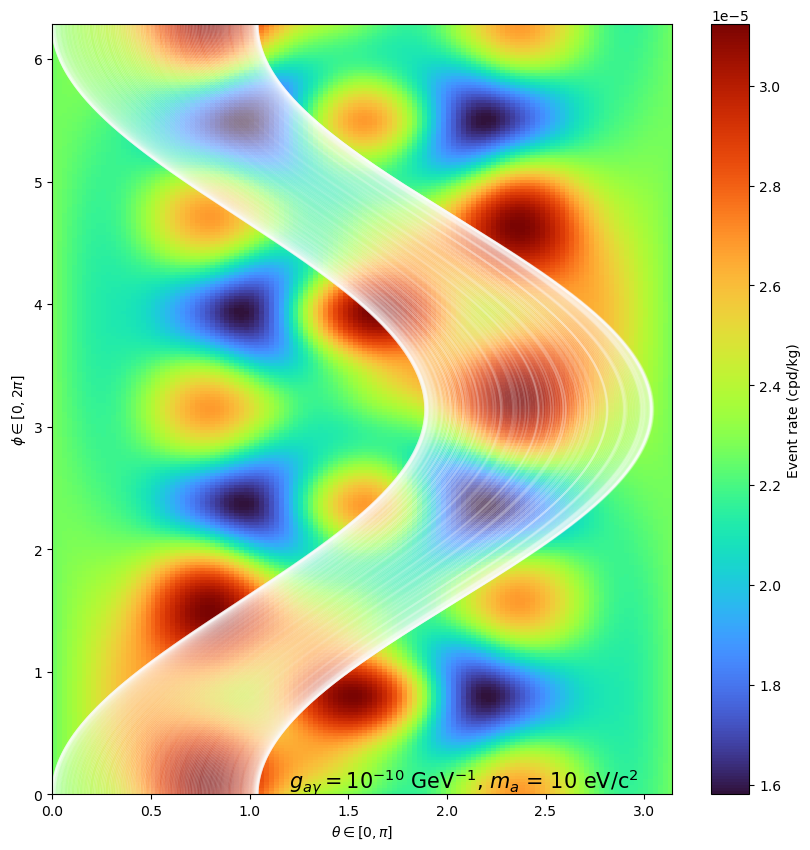

In [6]:
fig,ax = plt.subplots(figsize=(10,10))
cpd = rates_square/(3*s_in_y)*86400/50
image = ax.imshow(cpd, interpolation='none', extent = (0,np.pi,0,2*np.pi), aspect='auto', origin='lower', cmap='turbo')
#path = ax.plot(theta_phi(phi_axis), phi_axis, c="white")
#ax.scatter(alt_polar, az_rad, c="magenta")

phi_axis = np.arange(0, 2*np.pi, 0.01)
for triplet in fits:
    ax.plot(np.pi/2-cosine_func(phi_axis, *triplet), phi_axis, c="white", alpha=0.15)#

ax.set_xlim([0, np.pi])

cbar = plt.colorbar(image)
cbar.set_label("Event rate (cpd/kg)")
#plt.title("Dual Condition (h,k,l even)")
plt.text(1.2, 0.05, "$g_{a\gamma} = 10^{-10}$ GeV$^{-1}$, $m_a$ = 10 eV/c$^2$", color="black", fontsize=15)
plt.xlabel("$\\theta \in [0,\pi]$")
plt.ylabel("$\phi \in [0,2\pi]$")
#plt.savefig("Plots\\angle_dependence_v3.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
used_g = 1e-10 
used_m = 0.01
t_exposure = 5
lines_annual = annual_change(coupling = used_g, time=t_exposure, m_a = used_m)
#4m18.3s runtime

C:\Users\taase\AppData\Local\Temp\ipykernel_21520\23494177.py:22: RuntimeWarning: divide by zero encountered in divide
  E_arr = hbar_kevs*c_aas*np.sqrt(mod2_g)/(2*gk) #in keV
c:\Users\taase\OneDrive\Documents\School\Unimelb\Winter Project\Axion-Flux\Clean\axion_functions.py:120: RuntimeWarning: overflow encountered in exp
  val = np.sqrt(lmda)*phi_e0*E*(E**2 - m_a**2)/(np.exp(E/1.1) - 0.7)*(1+0.02*m_a)


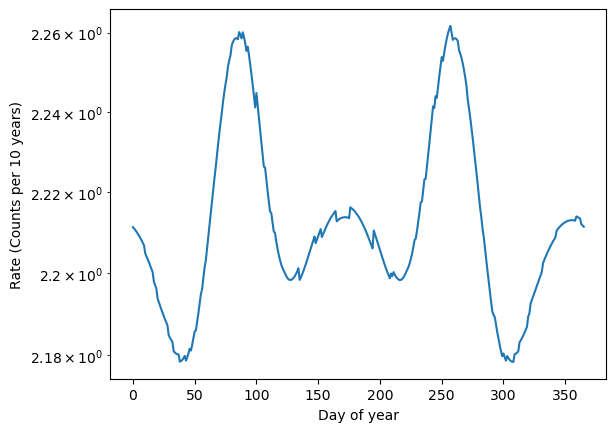

In [9]:
fig, ax = plt.subplots()
ax.set_yscale("log")
plt.xlabel("Day of year")
plt.ylabel("Rate (Counts per 10 years)")
ax.plot(range(0,366), lines_annual/(2*np.pi))